# Import libraries

In [1]:
import datetime

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import pycountry
import re

from tqdm import tqdm
tqdm.pandas()

from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein
from strsimpy.jaro_winkler import JaroWinkler
from strsimpy.metric_lcs import MetricLCS

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns
sns.set()
sns.set_style("whitegrid")

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit


from scipy.sparse import csr_matrix

import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import precision_recall_curve


# import googletrans
# from googletrans import Translator
import cyrtranslit
from unidecode import unidecode

# Functions

In [2]:
# convert text to lowercase
def lower_str(data,column):
    data[column] = data[column].str.lower()

In [3]:
def contingency_table(X,features,probability_level,tridx,cvidx,model):
    tr_predict_proba = model.predict_proba(X.iloc[tridx][features].values)
    cv_predict_proba = model.predict_proba(X.iloc[cvidx][features].values)

    tr_predict_target = (tr_predict_proba[:, 1] > probability_level).astype(np.int)
    cv_predict_target = (cv_predict_proba[:, 1] > probability_level).astype(np.int)

    X_tr = X.iloc[tridx]
    X_cv = X.iloc[cvidx]

    X_tr['predict_proba'] = tr_predict_proba[:,1]
    X_cv['predict_proba'] = cv_predict_proba[:,1]

    X_tr['predict_target'] = tr_predict_target
    X_cv['predict_target'] = cv_predict_target

    # make true positive column
    data = pd.DataFrame(X_tr[X_tr['target']==1][X_tr['predict_target']==1]['pair_id'])
    data['True_Positive'] = 1
    X_tr = X_tr.merge(data,on='pair_id',how='left')

    data = pd.DataFrame(X_cv[X_cv['target']==1][X_cv['predict_target']==1]['pair_id'])
    data['True_Positive'] = 1
    X_cv = X_cv.merge(data,on='pair_id',how='left')

    # make false positive column
    data = pd.DataFrame(X_tr[X_tr['target']==0][X_tr['predict_target']==1]['pair_id'])
    data['False_Positive'] = 1
    X_tr = X_tr.merge(data,on='pair_id',how='left')

    data = pd.DataFrame(X_cv[X_cv['target']==0][X_cv['predict_target']==1]['pair_id'])
    data['False_Positive'] = 1
    X_cv = X_cv.merge(data,on='pair_id',how='left')

    # make true negative column
    data = pd.DataFrame(X_tr[X_tr['target']==0][X_tr['predict_target']==0]['pair_id'])
    data['True_Negative'] = 1
    X_tr = X_tr.merge(data,on='pair_id',how='left')

    data = pd.DataFrame(X_cv[X_cv['target']==0][X_cv['predict_target']==0]['pair_id'])
    data['True_Negative'] = 1
    X_cv = X_cv.merge(data,on='pair_id',how='left')

    # make false negative column
    data = pd.DataFrame(X_tr[X_tr['target']==1][X_tr['predict_target']==0]['pair_id'])
    data['False_Negative'] = 1
    X_tr = X_tr.merge(data,on='pair_id',how='left')

    data = pd.DataFrame(X_cv[X_cv['target']==1][X_cv['predict_target']==0]['pair_id'])
    data['False_Negative'] = 1
    X_cv = X_cv.merge(data,on='pair_id',how='left')
    
    return X_tr,X_cv

In [4]:
def matrix_confusion(X):

    list_matrix = ['True_Positive','False_Positive','True_Negative','False_Negative']

    tr_pos = X[list_matrix].sum().loc['True_Positive']
    f_pos = X[list_matrix].sum().loc['False_Positive']
    tr_neg = X[list_matrix].sum().loc['True_Negative']
    f_neg = X[list_matrix].sum().loc['False_Negative']
    matrix_confusion = pd.DataFrame()
    matrix_confusion['0_algorythm'] = np.array([tr_neg,f_neg]).T
    matrix_confusion['1_algorythm'] = np.array([f_pos,tr_pos]).T
    matrix_confusion = matrix_confusion.rename(index={0: '0_target', 1: '1_target'})
    
    return matrix_confusion

In [5]:
def report_score(tr_matrix_confusion,
                 cv_matrix_confusion,
                 data,tridx,cvidx,
                 X_tr,X_cv):
    # print some imporatant information
    print ('\033[1m'+'Matrix confusion on train data'+'\033[m')
    display(tr_matrix_confusion)
    print ()
    print(classification_report(data.iloc[tridx]["target"].values, X_tr['predict_target']))
    print ('******************************************************')
    print ()
    print ()
    print ('\033[1m'+'Matrix confusion on test(cv) data'+'\033[m')
    display(cv_matrix_confusion)
    print ()
    print(classification_report(data.iloc[cvidx]["target"].values, X_cv['predict_target']))
    print ('******************************************************')

In [6]:
def table_gain_coef(model,features,start,stop):
    
    data_gain = pd.DataFrame()
    data_gain['Features'] = features
    data_gain['Gain'] = model.booster_.feature_importance(importance_type='gain')
    return data_gain.sort_values('Gain', ascending=False)[start:stop]

In [7]:
def gain_hist(df,size,start,stop):
    fig, ax = plt.subplots(figsize=(size))
    x = (df.sort_values('Gain', ascending=False)['Features'][start:stop])
    y = (df.sort_values('Gain', ascending=False)['Gain'][start:stop])
    plt.bar(x,y)
    plt.xlabel('Features')
    plt.ylabel('Gain')
    plt.xticks(rotation=90)
    plt.show()

In [8]:
def gini_df(model,features,start,stop):
    
    data_gini = pd.DataFrame()
    data_gini['feature'] = features
    data_gini['gini'] = model.feature_importances_
    return data_gini.sort_values('gini', ascending=False)[start:stop]

In [9]:
def gini_hist(df,size):
    fig, ax = plt.subplots(figsize=(size))
    x = (df.sort_values('gini', ascending=False)['feature'])
    y = (df.sort_values('gini', ascending=False)['gini'])
    plt.bar(x,y)
    plt.xlabel('feature')
    plt.ylabel('gini')
    plt.xticks(rotation=90)
    plt.show()

In [10]:
def logreg_df(model,features,start,stop):
    
    data_logreg = pd.DataFrame()
    data_logreg['feature'] = features
    data_logreg['coef'] = model.coef_.reshape(-1)
    return data_logreg.sort_values('coef', ascending=False)[start:stop]

In [11]:
def logreg_hist(df,size):
    fig, ax = plt.subplots(figsize=(size))
    x = (df.sort_values('coef', ascending=False)['feature'])
    y = (df.sort_values('coef', ascending=False)['coef'])
    plt.bar(x,y)
    plt.xlabel('feature')
    plt.ylabel('coef')
    plt.xticks(rotation=90)
    plt.show()

In [12]:
def compair_metrics(data):
    duplicate_count = []
    duplicate_sum = []
    for i in range(len(data)):
        count=len(data[i])
        duplicate_count.append(count)
        if count <= 0:
            duplicate_sum.append(0)
        elif count > 0:
            temp_sum = 0
            for j in range(len(data[i])):
                temp_sum +=len(data[i][j])
            duplicate_sum.append(temp_sum)

    return duplicate_count,duplicate_sum    

In [13]:
def transliterate(data):
    text_transliterate = []
    for i in range(data.shape[0]):
        temp_list = list(data[i:i+1])
        temp_str = ''.join(temp_list)
        result = cyrtranslit.to_latin(temp_str,'ru')
        text_transliterate.append(result)
    return text_transliterate

In [14]:
def rename_agg_columns(id_client,data,rename):
    columns = [id_client]
    for lev_0 in data.columns.levels[0]:
        if lev_0 != id_client:
            for lev_1 in data.columns.levels[1][:-1]:
                columns.append(rename % (lev_0, lev_1))
    data.columns = columns
    return data

In [15]:
# draw graph for analyse two choosing features for predict traget label
def two_features(data,analyse1,analyse2,size):
    fig = plt.subplots(figsize=size)
    
    x0 = data[data['target']==0][analyse1]
    y0 = data[data['target']==0][analyse2]
    x1 = data[data['target']==1][analyse1]
    y1 = data[data['target']==1][analyse2]
    
    plt.scatter(x1,y1,c='green',marker='.',s=400,label='duplicates')
    plt.scatter(x0,y0,c='black',marker='+',s=40,label='different words')
    plt.xlabel(analyse1)
    plt.ylabel(analyse2)
    title = [analyse1,analyse2]
    plt.title(title)
    plt.legend(loc=8,fontsize=8)
    plt.show()

In [16]:
# contingency table for categorical and discrete data

def contingency_table_2(data,analyse,title_print):
    ct = pd.crosstab(data['target'], data[analyse].fillna('no_data'))
    ct.loc['sum'] = ct.sum()
    ct.loc['duplicates_%_(1)'] = ct.loc[1]/ct.loc['sum']*100
    ct.loc['duplicates_%_(1)'] = list(map(lambda x: round(x,2), ct.loc['duplicates_%_(1)']))
    ct.loc['share_of_objects_%'] = ct.loc['sum']/ct.loc['sum'].sum(axis=0)*100
    ct.loc['share_of_objects_%'] = list(map(lambda x: round(x,1), ct.loc['share_of_objects_%']))
    
    if title_print == 'yes':
        print ('\033[1m' + 'Таблица сопряженности' + '\033[m')
    elif title_print == 'no':
        None
    
    return ct

In [17]:
# pair histogramms for categorical and discrete data

def pair_hist(ct,size,title_print):
    
    if title_print == 'yes':
        print ('Признак:','\033[1m',analyse,'\033[m')
    elif title_print == 'no':
        None
    
    width =0.3

    fig, ax = plt.subplots(figsize=(size))

    x = ct.columns
    y0 = ct.loc['share_of_objects_%']
    y1 = ct.loc['duplicates_%_(1)']
    rects1 = ax.bar(np.arange(len(x)) - width/2, y1, width, color='darkgreen', label='% duplicates')
    rects2 = ax.bar(np.arange(len(x)) + width/2, y0, width, color='black', label='% not duplicates')
    ax.set_title(analyse)
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(x)
    if len(x) > 10:    
            plt.xticks(rotation=90)
    ax.legend(loc=9,fontsize=8)
    plt.xlabel(analyse)
    plt.ylabel('%')
    plt.show()

In [18]:
# statistic table for analyse float values (it needs to make histogramms and boxplots)
def data_statistics(data,analyse,title_print):

    data0 = data[data['target']==0][analyse]
    data1 = data[data['target']==1][analyse]

    data_describe = pd.DataFrame()
    data_describe['target_0'] = data0.describe()
    data_describe['target_1'] = data1.describe()
    data_describe = data_describe.T
    
    if title_print == 'yes':
        print ('\033[1m' + 'Дополнительные статистики по признаку',analyse,'\033[m') 
    elif title_print == 'no':
        None
    
    return data_describe

In [19]:
# histogramms for float values
def hist_fz(data,data_describe,analyse,size):
    print ()
    print ('\033[1m' + 'Information about',analyse,'\033[m')
    print ()
    
    data_0 = data[data['target'] == 0][analyse]
    data_1 = data[data['target'] == 1][analyse]
    
    min_data = data_describe['min'].min()
    max_data = data_describe['max'].max()
    
    data0_mean = data_describe.loc['target_0']['mean']
    data0_median = data_describe.loc['target_0']['50%']
    data0_min = data_describe.loc['target_0']['min']
    data0_max = data_describe.loc['target_0']['max']
    data0_count = data_describe.loc['target_0']['count']
    
    
    data1_mean = data_describe.loc['target_1']['mean']
    data1_median = data_describe.loc['target_1']['50%'] 
    data1_min = data_describe.loc['target_1']['min']
    data1_max = data_describe.loc['target_1']['max']
    data1_count = data_describe.loc['target_1']['count']
    
    
    print ('\033[4m' + 'Analyse'+ '\033[m','No duplicates')
    
    figure(figsize=size)
    sns.distplot(data_0,color='darkgreen',kde = False)
    
    plt.scatter(data0_mean,0,s=200,marker='o',c='dimgray',label='Mean')
    plt.scatter(data0_median,0,s=250,marker='|',c='black',label='Median')
    plt.legend(scatterpoints=1,
               loc='upper right',
               ncol=3,
               fontsize=16)
    plt.xlim(min_data, max_data)
    plt.show()
    print ('Count:', data0_count,
           '    Avg:', round(data0_mean,2),
           '    Std:', round(data_describe.loc['target_0']['std'],2),
           '    Median:', round(data0_median,2),
           '    Min:', round(data0_min,2),
           '    Max:', round(data0_max,2)
)
    
    print ()
    print ('\033[4m' + 'Analyse'+ '\033[m','Duplicates')
    
    figure(figsize=size)
    sns.distplot(data_1,color='darkred',kde = False)
    plt.scatter(data1_mean,0,s=200,marker='o',c='dimgray',label='Mean')
    plt.scatter(data1_median,0,s=250,marker='|',c='black',label='Median')
    plt.legend(scatterpoints=1,
               loc='upper right',
               ncol=3,
               fontsize=16)
    plt.xlim(min_data, max_data)
    plt.show()
    print ('Count:', data_1.count(),
           '    Avg:', round(data1_mean,2),
           '    Std:', round(data_describe.loc['target_1']['std'],2),
           '    Median:', round(data1_median,2),
           '    Min:', round(data1_min,2),
           '    Max:', round(data1_max,2)
          )

In [20]:
# draw boxplot
def boxplot(data,analyse,size):
    print ('\033[4m' + 'Analyse'+ '\033[m','All pairs')
    
    data_0 = data[data['target'] == 0][analyse]
    data_1 = data[data['target'] == 1][analyse]
    
    figure(figsize=size)
    sns.boxplot(x=analyse,y='target',data=data,orient='h',
                showmeans=True,                
                meanprops={"marker":"o",
                           "markerfacecolor":"dimgray", 
                           "markeredgecolor":"black",
                          "markersize":"14"},
               palette=['palegreen', 'salmon'])
    plt.ylabel('target', size=14)
    plt.xlabel(analyse, size=14)
    plt.show()

In [21]:
def dplct_words(a, b):
    a = set(a.split())
    b = set(b.split())
    return len(a & b)

def difrnt_words(a, b):
    a = set(a.split())
    b = set(b.split())
    return len(a-b|b-a)

def dplct_symbls(a,b):
    a = set(a.split())
    b = set(b.split())
    symbols = 0
    for num in range(len(list(a & b))):
        symbols += (len(list(a & b)[num]))
    return symbols

def difrnt_symbls(a,b):
    a = set(a.split())
    b = set(b.split())
    set_ab = list(a-b|b-a)
    sum_ab = 0
    for i in set_ab:
        sum_ab += len(i)
    return sum_ab

def dplct_frst_s(a,b):
    a = re.sub('\s', '', a)
    b = re.sub('\s', '', b)
    idx = 0
    minlen = min(len(a), len(b))
    while idx < minlen and a[idx] == b[idx]:
        idx += 1
    return idx

def dplct_last_s(a,b):
    return dplct_frst_s(a[::-1], b[::-1])

def lbl_subset(a,b):
    if a == '' or b == '':
        return False
    a = set(a.split())
    b = set(b.split())
    return a.issubset(b) or b.issubset(a)

def lbl_substr(a, b):
    if a == '' or b == '':
        return False
    a = sorted(set(a.split()))
    b = sorted(set(b.split()))
    a = ''.join(a)
    b = ''.join(b)
    return a in b or b in a

In [22]:
def ad_all(data,col1,col2,new_col):
    data[new_col] = data[col1]+data[col2]
    return np.array(data[new_col])

def sub(data,col1,col2,new_col):
    data[new_col] = data[col1]-data[col2]
    return np.array(data[new_col])

def rt_avg(data,col1,col2,new_col):
    data[new_col] = data[col1]/data[col2]
    return np.array(data[new_col])

In [23]:
def preprocess(data,column):
#     convert text to lowercase
    data[column] = data[column].str.lower()
#     drop punctuation marks
    data[column].replace(re.compile(r"\s+\(.*\)"), "", inplace=True)
    data[column].replace(re.compile(r"[^\w\s]"), "", inplace=True)
#     transliterate
    list_str = pd.Series(data[column], dtype="string")
    new_data = []
    [new_data.append(unidecode(row)) for row in list_str]
    data[column] = new_data
#     drop punctuation marks
    data[column].replace(re.compile(r"\s+\(.*\)"), "", inplace=True)
    data[column].replace(re.compile(r"[^\w\s]"), "", inplace=True)

In [24]:
def get_threshold(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    f_score = []
    for idx, val in enumerate(thresholds):
        f_score.append(2 * precision[idx] * recall[idx] / (precision[idx] + recall[idx]))
    THR = thresholds[np.array(f_score).argmax()]
    return THR

In [25]:
def drop_hfw(dictionary,data_frames,old_columns,new_columns):
    for df in data_frames:
        for num in range(len(old_columns)):
            df[new_columns[num]] =\
            df[old_columns[num]].apply(
            lambda x: ' '.join([word for word in x.split() if word not in (list(dictionary.keys()))]))

# Create features part 1:
*(some important distances)*

## *Create label if both of cells are empty:*
 - **label** if the both names of companies have zero words (they are empty): 
        - label 0 when here is empty in names of companies
        - label 1 else

## *Count Levenstein and normilized Levenstein distances:*
 - **levenstein** distance after drop all selected high-frequency words
 - **Normalized levenstein** distance
 
## *Count Jaro-Winkler distance:*
 - **Jaro Winkler distance** after drop all selected high-frequency words
 
## *Count distance metric based on Longest Common Subsequence:*
 - **Distance LCS** after drop all selected high-frequency words
 
## *Ratios:*
 - ratio between **levenstein** distance and **label 0** if names are empty
 - ratio between **normalized levenstein** distance and **label 0**
 - ratio between **jaro** distance and **label 0**
 - ratio between **distance LCS** and **label 0**

In [25]:
def lbl_empty(data,column_1,column_2,new_column):
    temp = pd.DataFrame(data[data[column_1]==''][data[column_2]=='']['pair_id'])
    temp[new_column] = 0
    data = data.merge(temp,on='pair_id',how='left')
    data[new_column] = data[new_column].fillna(1)
    return data

In [26]:
def count_distances(data_frames,column_1,column_2,number):
    # Create feature: LEVENSTAIN DISTANCE between names of companies
    new_column = 'lvstn_%s' %number
    levenshtein = Levenshtein()
    for data in data_frames:
        data[new_column] = data.progress_apply(
            lambda r: levenshtein.distance(r[column_1], r[column_2]), axis=1)

    # Create feature: NORMILIZED LEVENSTAIN DISTANCE between names of companies   
    new_column = 'norm_lvstn_%s' %number
    normalized_levenshtein = NormalizedLevenshtein()
    for data in data_frames:
        data[new_column] = data.progress_apply(
            lambda r: normalized_levenshtein.distance(r[column_1], r[column_2]), axis=1)

    # Create feature: Jaro-Winkler distance between names of companies
    new_column = 'jaro_%s' %number
    jaro = JaroWinkler()

    for data in data_frames:
        data[new_column] = data.progress_apply(
            lambda r: jaro.similarity(r[column_1], r[column_2]), axis=1)  

    # Create feature: LCS distance between names of companies    
    new_column = 'LCS_%s' %number
    metric_lcs = MetricLCS()

    for data in data_frames:
        data[new_column] = data.progress_apply(
            lambda r: metric_lcs.distance(r[column_1], r[column_2]), axis=1)

    # Create RATIOS (every distances to sign of empty label):
    new_ratios = ['rt_lvstn_%s' %number,'rt_norm_lvstn_%s' %number,
                  'rt_jaro_%s' %number,'rt_LCS_%s' %number]

    use_distances = ['lvstn_%s' %number,'norm_lvstn_%s' %number,
                     'jaro_%s' %number,'LCS_%s' %number]

    use_label = 'lbl_empty_%s' %number

    for data in data_frames:
        for num in range(len(new_ratios)):
            data[new_ratios[num]] = data[use_distances[num]] / data[use_label]

# Сreate features part 2:
*(information about similar and different words and symbols in pairs of company names):*

## *Similar and dudplicate words*
 - **duplct_wrds** - count of duplicate words
 - **duplct_smbls** - the sum of the_symbols in duplicate words
 - **frst_s** - the sum of the first repeated symbols
 - **last_s** - the sum of the last repeated symbols


## *Different words*
 - **dif_wrds** - count of different words
 - **dif_smbls** - sum of symbols in duplicate words
 
 
## *Labels*
 - **subset** - if one name contain all the words of another in the beginning sign it 1, else 0
 - **subsetr** - if one name contain all the words of another sign it 1, else 0
 
## *Additional*
 - **sum_wrds** - sum of count of the duplicate and different words
 - **sum_smbls** - sum of all symbols in the names of companies
 
## *Subtraction*
 - **subtr_wrds** - differences between count of duplicate and different words
 - **subtr_symb** - differences between the sum of the symbols in duplicate and different words
 
## *Ratios*
 - **avg_smbls_duplct** - ratio between sum of symbols and count of duplicate words. Else can say: average number of symbols in a duplicate word;
 - **avg_smbls_dif** - ratio between sum of symbols and count of different words. Else can say: average number of symbols in a different word;
 - **avg_frst_s** - ratio between the sum of the first repeated symbols and sum of the all symbols in the name of company
 - **avg_last_s** - ratio between the sum of the last repeated symbols and sum of the all symbols in the name of company 
 - **rt_dplct_to_dif_wrds** - ratio between count of duplicate and different words in the pair
 - **rt_dplct_to_sum_wrds** - ratio between count of duplicate and all words in the pair

In [27]:
def dupl_and_diff_information(data_frames,col1,col2):

    # Create feature: count of duplicate words
    new_column = 'duplct_wrds_%s' %number
    for data in data_frames:
        data[new_column] = data.apply(lambda x: dplct_words(x[col1], x[col2]),axis=1)

    # Create feature: count of different words
    new_column = 'dif_wrds_%s' %number
    for data in data_frames:
        data[new_column] = data.apply(lambda x: difrnt_words(x[col1], x[col2]),axis=1)

    # Create feature: the sum of the_symbols in duplicate words
    new_column = 'duplct_smbls_%s' %number
    for data in data_frames:
        data[new_column] = data.apply(lambda x: dplct_symbls(x[col1], x[col2]),axis=1)

    # Create feature: the sum of the_symbols in different words
    new_column = 'dif_smbls_%s' %number
    for data in data_frames:
        data[new_column] = data.apply(lambda x: difrnt_symbls(x[col1], x[col2]),axis=1)

    # Create feature: the sum of the first repeated symbols
    new_column = 'frst_s_%s' %number
    for data in data_frames:
        data[new_column] = data.apply(lambda x: dplct_frst_s(x[col1], x[col2]),axis=1)

    # Create feature: the sum of the last repeated symbols
    new_column = 'last_s_%s' %number
    for data in data_frames:
        data[new_column] = data.apply(lambda x: dplct_last_s(x[col1], x[col2]),axis=1)

    # Create feature: if one name contain all the words of another in the begining sign it 1, else 0
    new_column = 'subset_%s' %number
    for data in data_frames:
        data[new_column] = data.apply(lambda x: lbl_subset(x[col1], x[col2]),axis=1)

    # Create feature: if one name contain all the words of another sign it 1, else 0
    new_column = 'subsetr_%s' %number
    for data in data_frames:
        data[new_column] = data.apply(lambda x: lbl_substr(x[col1], x[col2]),axis=1)

    # Create feature: sum of count of the duplicate and different words ('ad_all_words_%s' %number)
    new_col = 'sum_wrds_%s' %number
    col1 = 'duplct_wrds_%s' %number
    col2 = 'dif_wrds_%s' %number
    for data in data_frames:
        data.new_col = ad_all(data,col1,col2,new_col)

    # Create feature: sum of all symbols in the names of companies ('ad_all_symbols_%s' %number)
    new_col = 'sum_smbls_%s' %number
    col1 = 'duplct_smbls_%s' %number
    col2 = 'dif_smbls_%s' %number
    for data in data_frames:
        data.new_col = ad_all(data,col1,col2,new_col)

    # Create feature: differences between count of duplicate and different words ('sub_words_%s' %number)
    new_col = 'subtr_wrds_%s' %number
    col1 = 'duplct_wrds_%s' %number
    col2 = 'dif_wrds_%s' %number
    for data in data_frames:
        data.new_col = sub(data,col1,col2,new_col)

    # Create feature: differences between the sum of the symbols in duplicate and different words ('sub_symbls_%s' %number)
    new_col = 'subtr_symb_%s' %number
    col1 = 'duplct_smbls_%s' %number
    col2 = 'dif_smbls_%s' %number
    for data in data_frames:
        data.new_col = sub(data,col1,col2,new_col)

    # Create feature: ratio between sum of symbols and count of duplicate words ('rt_avg_dplct_%s' %number)
    new_col = 'avg_smbls_duplct_%s' %number
    col1 = 'duplct_smbls_%s' %number
    col2 = 'duplct_wrds_%s' %number
    for data in data_frames:
        data.new_col = rt_avg(data,col1,col2,new_col)

    # Create feature: ratio between sum of symbols and count of different words ('rt_avg_difrnt_%s' %number)
    new_col = 'avg_smbls_dif_%s' %number
    col1 = 'dif_smbls_%s' %number
    col2 = 'dif_wrds_%s' %number
    for data in data_frames:
        data.new_col = rt_avg(data,col1,col2,new_col)

    # Create feature: ratio between 
            # the sum of the first repeated symbols and
            # sum of the all symbols in the name of company ('rt_avg_frst_%s' %number)
    new_col = 'avg_frst_s_%s' %number
    col1 = 'frst_s_%s' %number
    col2 = 'sum_smbls_%s' %number
    for data in data_frames:
        data.new_col = rt_avg(data,col1,col2,new_col)   

    # Create feature: ratio between 
            # the sum of the last repeated symbols and
            # sum of the all symbols in the name of company ('rt_avg_last_%s' %number)
    new_col = 'avg_last_s_%s' %number
    col1 = 'last_s_%s' %number
    col2 = 'sum_smbls_%s' %number
    for data in data_frames:
        data.new_col = rt_avg(data,col1,col2,new_col)    


    # Create feature: ratio between count of duplicate and different words in the pair ('rt_avg_dplct_%s' %number)
    new_col = 'rt_dplct_to_dif_wrds_%s' %number
    col1 = 'duplct_wrds_%s' %number
    col2 = 'dif_wrds_%s' %number
    for data in data_frames:
        data.new_col = rt_avg(data,col1,col2,new_col)

    # Create feature: ratio between count of duplicate and all words in the pair ('rt_avg_dplct_%s' %number)
    new_col = 'rt_dplct_to_sum_wrds_%s' %number
    col1 = 'duplct_wrds_%s' %number
    col2 = 'sum_wrds_%s' %number
    for data in data_frames:
        data.new_col = rt_avg(data,col1,col2,new_col)

In [28]:
def ratios(data,start,stop):
    data['mult_avg_smbls_duplct_%s_%s' %(start,stop)] = \
      data['avg_smbls_duplct_%s' %start] \
    * data['avg_smbls_duplct_%s' %stop]

    data['mult_smbls_duplct_%s_%s' %(start,stop)] = \
      data['duplct_smbls_%s' %start] \
    * data['duplct_smbls_%s' %stop]

    data['mult_frst_s_%s_%s' %(start,stop)] = \
      data['frst_s_%s' %start] \
    * data['frst_s_%s' %stop]
      
    data['mult_avg_frst_s_%s_%s' %(start,stop)] = \
      data['avg_frst_s_%s' %start] \
    * data['avg_frst_s_%s' %stop]

    data['mult_rt_dplct_to_sum_wrds_%s_%s' %(start,stop)] = \
      data['rt_dplct_to_dif_wrds_%s' %start] \
    * data['rt_dplct_to_dif_wrds_%s' %stop]

    data['rt_duplct_to_dif_wrds_%s_%s' %(start,stop)] = \
      (data['duplct_wrds_%s' %start] + data['duplct_wrds_%s' %stop]) \
    / (data['dif_wrds_%s' %start] + data['dif_wrds_%s' %stop])
        
    return data

In [29]:
# Upgrade matrix

# There are three meanings for each holding: 0,1,2
# 0 - means no name holding in both companies of the pair
# 1 - means one name holding in any company name from a pair
# 2 - means that each company name from a pair has a name holding

def df_holdings_names(data_new,data_orig):
    name_company = 'name_1_dl'
    data_new[name_company] = data_orig[name_company]
    columns_drop = []
    for holding in holdings:
        column = 'n1_%s' % holding
        columns_drop.append(column)
        data_new[column] = data_orig[name_company]
        data_new[column] = data_orig[name_company].apply(
            lambda x: ' '.join(['1' for i in x.split() if i == holding]))
        data_new.loc[data_new[column]!='',column]=1
        data_new.loc[data_new[column]=='',column]=0

    name_company = 'name_2_dl'
    data_new[name_company] = data_orig[name_company]
    for holding in holdings:
        column = 'n2_%s' % holding
        columns_drop.append(column)
        data_new[column] = data_orig[name_company]
        data_new[column] = data_orig[name_company].apply(
            lambda x: ' '.join(['1' for i in x.split() if i == holding]))
        data_new.loc[data_new[column]!='',column]=1
        data_new.loc[data_new[column]=='',column]=0  

    for holding in holdings:   
        column = '%s_sum' % holding
        n1 = 'n1_%s' % holding
        n2 = 'n2_%s' % holding
        data_new[column] = data_new[n1] + data_new[n2]

    data_new = data_new.drop(columns_drop,axis=1)
    
    return data_new

In [30]:
def replace_ooo(data,columns):
    for column in columns:
        data[column] = data[column].str.replace("ooo","")
    return data

In [31]:
def crosvalscore_lgbm_classifier(data,features,PARAMS):

    df = pd.DataFrame()
    df[features] = data[features]
    df['target'] = data['target']

    X = np.array(df[features])
    y = np.array(df['target'])

    kf = StratifiedKFold(n_splits=FOLDS,shuffle=True,random_state=SEED)

    idx_tr = []
    idx_tst = []
    fold = 1
    for train_index, test_index in kf.split(X,y):
        idx_tr.append(train_index)
        idx_tst.append(test_index)

    proba_cv = []
    scores = []
    for i in range(FOLDS):
        model = lgb.LGBMClassifier(**PARAMS)
        model.fit(
            df.loc[idx_tr[i]][features].values,
            df.loc[idx_tr[i]]['target'].values)
        proba_cv.append(1-(model.predict_proba(
        df[features].values)[:, 0].astype(np.float)))
        df['proba_cv%s'%(i+1)] = proba_cv[i]
        probability_level = get_threshold(df.loc[idx_tst[i]]['target'],
                                          df.loc[idx_tst[i]]['proba_cv%s'%(i+1)])
        df['lvl_probblty%s'%(i+1)] = probability_level
        df['lvl_probblty%s'%(i+1)] = df['lvl_probblty%s'%(i+1)].round(4)
        df['predict_cv%s'%(i+1)] = (model.predict_proba(
        df[features].values)[:, 1] > (probability_level)).astype(np.int)
        df['train_cv%s'%(i+1)] = False
        df['train_cv%s'%(i+1)].loc[idx_tr[i]] = True
        score = f1_score(y_true=df.loc[idx_tst[i]]['target'],
                 y_pred=df.loc[idx_tst[i]]['predict_cv%s'%(i+1)])
        df['f1_score_cv%s'%(i+1)] = score
        df['f1_score_cv%s'%(i+1)] = df['f1_score_cv%s'%(i+1)].round(3)
        scores.append(score)
        df['proba_cv%s'%(i+1)] = df['proba_cv%s'%(i+1)].round(4)
        print ('fold: %s'%(i+1),', score:',round(score,4),
               ', time:', datetime.datetime.now().strftime("%H:%M:%S"))

    
    return df,scores,idx_tr,idx_tst

# Download data

In [32]:
# DOWNLOAD DATA
text_train = pd.read_csv('train.csv')
text_test = pd.read_csv('test.csv')

# RENAME DATA
text_train = text_train.rename(columns={"is_duplicate": "target"})

# ANALYSE BALANCE OF DATA
target_1 = text_train[text_train['target']==1]['target'].count()
target_0 = text_train[text_train['target']==0]['target'].count()

print ('There are', target_1, 'objects with target 1')
print ('There are', target_0, 'objects with target 0')
print ('Balance is', round(100*target_1/target_0,2),'%')

There are 3658 objects with target 1
There are 494161 objects with target 0
Balance is 0.74 %


# Preprocessing data

In [35]:
# make copy data
train = text_train.copy()
test = text_test.copy()

In [36]:
# test_data[0:130000]['name_1']

In [37]:
# Preprocessing data (convert to lowercase, drop punctuation marks, transliterate, again drop punctuation marks)

    # select columns
columns = ['name_1','name_2']
# select train data
data = train
for column in columns:
    preprocess(data,column)

    # select test data
data = test
for column in columns:
    preprocess(data,column)
    
    
# Drop any names of countries
countries = [country.name.lower() for country in pycountry.countries]
for country in tqdm(countries):
    train.replace(re.compile(country), "", inplace=True)
    test.replace(re.compile(country), "", inplace=True)

100%|██████████| 249/249 [08:29<00:00,  2.05s/it]


In [34]:
# Replace 'ooo' in text to ''

columns = ['name_1','name_2']
train = replace_ooo(train,columns)
test = replace_ooo(test,columns)

In [37]:
# Check how it was replaced
columns = ['pair_id','name_1','name_2']
train[columns][train['name_2'].str.contains('ooo')][0:5]

,pair_id,name_1,name_2


## Create dictionaries for drop words in text:
 - countries
 - cities
 - geographic objects
 - legal entites
 - hand made list of stop words

Unite them to one list - 'drop_list'.

In [38]:
countries = [
            'america', 'americas', 'bolivia', 'boliviana', 'brasil', 'brasil', 'brasileria',
    'ceska', 'columbia', 'czech', 'deutschland', 'euro', 'holland', 'italia', 'korea',
    'mexicana', 'nederland', 'polska', 'republic', 'republika', 'russia', 'shenzhen',
    'taiwan', 'usa', 'venezuela', 'vietnam','turkiye','thai','rus','goergia','rumunia','russland','eu'
]

In [39]:
capitals = ['andorra', 'kabul', 'tirana', 'yerevan', 'luanda', 
             'buenos aires', 'vienna', 'canberra', 'baku', 'bridgetown', 'dhaka', 'brussels', 
             'ouagadougou', 'sofia', 'manama', 'bujumbura', 'porto-novo', 'bandar seri begawan', 
             'sucre', 'nassau', 'thimphu', 'gaborone', 'minsk', 'belmopan', 
             'ottawa', 'kinshasa', 'brazzaville', 'yamoussoukro', 'santiago', 'yaounda', 'beijing', 
             'bogota¡', 'san josa', 'havana', 'praia', 'nicosia', 'prague', 'berlin', 'djibouti city',
             'copenhagen', 'roseau', 'santo domingo', 'quito', 'tallinn', 'cairo', 'asmara', 
             'addis ababa', 'helsinki', 'suva', 'paris', 'libreville', 'tbilisi', 'accra', 
             'banjul', 'conakry', 'athens', 'guatemala city', 'port au prince', 'bissau', 
             'georgetown', 'tegucigalpa', 'budapest', 'jakarta', 'dublin', 'jerusalem', 'new delhi',
             'baghdad', 'tehran', 'reykjavã\xadk', 'rome', 'kingston', 'amman', 'tokyo', 'nairobi',
             'bishkek', 'tarawa', 'pyongyang', 'seoul', 'kuwait city', 'beirut', 'vaduz', 'monrovia',
             'maseru', 'vilnius', 'luxembourg city', 'riga', 'tripoli', 'antananarivo', 'majuro', 
             'skopje', 'bamako', 'naypyidaw', 'ulaanbaatar', 'nouakchott', 'valletta', 'port louis',
             'malã', 'lilongwe', 'mexico city', 'kuala lumpur', 'maputo', 'windhoek', 'niamey', 
             'abuja', 'managua', 'amsterdam', 'oslo', 'kathmandu', 'yaren', 'wellington', 'muscat',
             'panama city', 'lima', 'port moresby', 'manila', 'islamabad', 'warsaw', 'lisbon', 
             'ngerulmud', 'asuncian', 'doha', 'bucharest', 'moscow', 'kigali', 'riyadh', 'honiara',
             'victoria', 'khartoum', 'stockholm', 'singapore', 'ljubljana', 'bratislava', 'freetown', 
             'san marino', 'dakar', 'mogadishu', 'paramaribo', 'damascus', 'loma',
             'bangkok', 'dushanbe', 'ashgabat', 'tunis', 'ankara',  
             'funafuti', 'dodoma', 'kiev', 'kampala', 'washington', 'montevideo', 'tashkent',
             'vatican', 'caracas', 'hanoi', 'lusaka', 'harare', 'algiers',
             'sarajevo', 'phnom penh', 'bangui', 'moroni', 'zagreb', 'dili', 'salvador', 
             'malabo', 'astana', 'vientiane', 'palikir', 'monaco',
             'podgorica', 'rabat', 'basseterre', 'castries', 'kingstown', 'apia', 'belgrade', 'pretoria',
             'madrid', 'sri jayewardenepura kotte', 'mbabane', 'bern', 'abu dhabi', 'london']

In [40]:
cities = [
    'beijing', 'cambridge', 'colorado', 'geneva', 'hongkong', 
    'kongsberg', 'montreal', 'shanghai', 'tokyo', 'toronto', 'vancouver','gongguan','huizhou','alpiarca',
    'michigan', 'roppongi','stargard',
    
    'czechy', 'russkaia', 'brasileira','shen','zhen','hangzhou', 'zhechen', 'shenyang','ua','yeosu','ria','stuttgart',
    'bochum','hungaria', ' ho', 'chi', 'minh',' hochiminh'
         ]

In [41]:
geographic_objects = [
    'africa','american', 'arab', 'arabian', 'asia', 'canadian', 'east', 'eastern', 'emirates', 'europe',
    'guangzhou', 'hindustan', 'italian', 'krishna', 'mahammed', 'mohammad',
    'north', 'north', 'northen', 'pacific', 'philippine', 'polynesie', 'south', 'southeast',
    'tropical', 'west','severozapad','severovostok','yugozapad','yugovostok','zapad','vostok','yug','sever',
    
    'northern'
            ]

In [42]:
legal_entities = [
    
    'agencies', 'agency', 'alliance', 'associated', 'broker', 'brokerage', 'bv',
     'co', 'code', 'companhia', 'corp', 'corporacion', 'corporation', 'custom', 'customer', 'customs',
     'enterprieses', 'expeditor', 'expeditors', 'gmb', 'gmbh', 'inc', 'ltd', 'ltda', 'manufactura', 'manufacture',
     'oao', 'office', 'ooo', 'pao', 'pty', 'pvt', 'royal', 'scrl', 'store', 'stores', 'terminal', 'trding',
     'zao','ao','sro','obshchestvo ogranichennoi otvetstvennost"iu', 'societas', 'sociedade','x','brothers',
    
    'kompaniia','gmph', 'obshchestvo', 'ogranichennoi', 'otvetstvennostiu','ink','incc','limited','division'
                 ]

In [43]:
type_works = ['industriali','industrial','indust','servis','produktion','work','works',
              
              'industrie', 'importadora','oil','gas']

In [44]:
# columns = ['pair_id','name_1_dl','name_2_dl']
# # train['name_1_ooo'] = train['name_1']

# # train['name_1_ooo'] = train['name_1_ooo'].str.replace("ooo","")

# # train[columns][train['name_1_dl'].str.contains('ooo')][0:50]
# train[columns][train['name_1_dl'].str.contains('ooo')][0:50]

In [45]:
# Unite the dictionaries to one list
drop_list = countries + capitals + cities + geographic_objects + legal_entities + type_works

### Drop the stop words

In [46]:
# Remove words from company names that are contained in the union list
data_frames = [train,test]
old_columns = ['name_1','name_2']
new_columns = ['name_1_dl','name_2_dl']

for data in data_frames:
    for num in range(len(old_columns)):
        data[new_columns[num]] =\
        data[old_columns[num]].apply(
        lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))

In [47]:
# # Check the train data
# train_data.head(3)

In [48]:
# # Check the test data
# test_data.head(3)

In [49]:
# # Check how the words have been removed 
# train_data[train_data.name_1.str.contains("czech republic")]

## Create dictionary of most high-frequency words

In [50]:
#  Make dictionary of frequency words
list_words = train['name_1_dl'].to_string(index=False).split() +\
                train['name_2_dl'].to_string(index=False).split()
freq_words = {}
for w in list_words:
    freq_words[w] = freq_words.get(w, 0) + 1
    
# Make a dataset from dictionary of frequency words. Aggregate and sort it
hfw = pd.DataFrame.from_dict(freq_words,orient='index')
hfw.columns = ['frequency']
hfw = hfw.sort_values(by=['frequency'], ascending=False)

### Look on most high-frequancy words

In [51]:
# # Look at the 50 most high frequency words in a sorted list  
# hfw_agg[0:50]

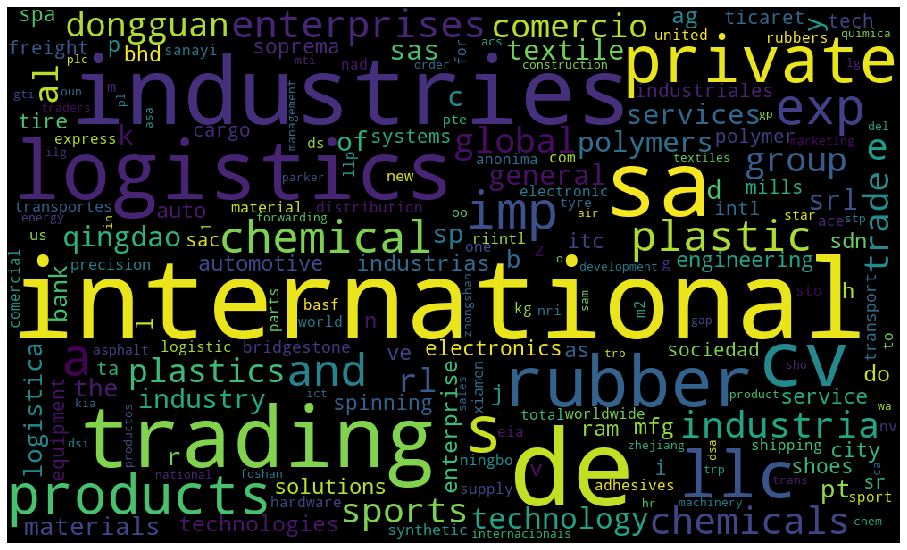

In [52]:
# Look at the 500 most high frequency words in work cloud
start = 0
stop = 500
dict_hfw = dict(zip(hfw.index[start:stop], hfw.frequency[start:stop]))
wordcloud = WordCloud(width=1000, height=600, random_state=0).generate_from_frequencies(dict_hfw)
plt.figure(figsize=(16, 10))
plt.imshow(wordcloud)
plt.axis('off');

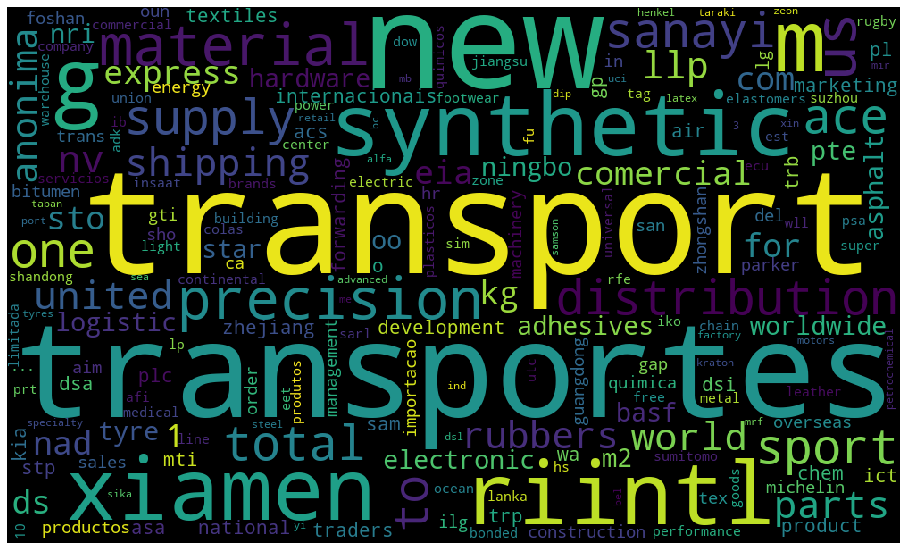

In [53]:
# Look at 100 the most high frequency words in work cloud
start = 100
stop = 500
dict_hfw = dict(zip(hfw.index[start:stop], hfw.frequency[start:stop]))
wordcloud = WordCloud(width=1000, height=600, random_state=0).generate_from_frequencies(dict_hfw)
plt.figure(figsize=(16, 10))
plt.imshow(wordcloud)
plt.axis('off');

We see a problem - there are some names of companies in 650 most of frequent words. Thats why we can't delete all 650 words and save all important information about names of companies in the same time. So, we need create a list names of companies for except names from dictionary of 650 most of frequent words. Better, if we do it automaticly. 

We will select the names of companies using ginni index of them names. We will select only 75 most important features (names holdings). 

## *Dictionary of most important names holdings*


*First, we count how many times every words from the 650 most of frequent words met per row (two names of the companies) and make dataset with these features and target.*

*Second, we fit lightgbm model on this dataset.*

*Third, we select ginny index per each feature and extract only 75 most important.*


### Matrix of high-frequency words

*The first step - make dataset (create matrix of 650 high-frequency words (h/f words))*

The creating matrix of 650 h/f words process needs a very long time. That way we decided download matrix in csv file. 

Now we can download matrix of h/f words and make dataset.

In [54]:
# Download matrix of most frequency words
df_650_mhfwords = pd.read_csv('matrix_sw_train_650.csv',index_col=0)

# Create dataset (merge target from train data with matrix of 650 most high-freaquency words)
holdings_data = train[['pair_id', 'name_1', 'name_2', 'target']].merge(
    df_650_mhfwords.drop(['name_1_finish','name_2_finish'],axis=1), on='pair_id', how='left')

In [55]:
# Select the parametres
    # select the features
features = holdings_data.columns[4:].tolist()

    # select the parameters of model
params = {
    'random_state':50,
    'min_samples_split':25,
    'max_depth': 50
         }

In [56]:
model = DecisionTreeClassifier(**params)
model.fit(holdings_data[features].values,
          holdings_data["target"].values)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=25,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=50, splitter='best')

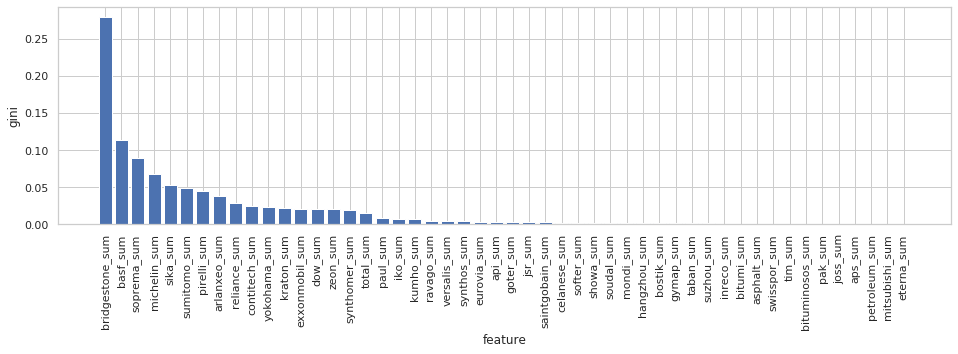

,feature,gini
68,bridgestone_sum,0.279417
108,basf_sum,0.112909
53,soprema_sum,0.089135
169,michelin_sum,0.068331
239,sika_sum,0.052425
171,sumitomo_sum,0.048648
409,pirelli_sum,0.044489
393,arlanxeo_sum,0.037661
270,reliance_sum,0.028922
636,contitech_sum,0.024743


In [57]:
start,stop = 0,50
size = (16,4)
df = gini_df(model,features,start,stop)
gini_hist(df,size)
display(df)

In [58]:
start,stop = 0,50
list_top_words = list(gini_df(model,features,start,stop)['feature'])
list_top_words = sorted(list_top_words)
print (list_top_words)

['api_sum', 'aps_sum', 'arlanxeo_sum', 'asphalt_sum', 'basf_sum', 'bitumi_sum', 'bituminosos_sum', 'bostik_sum', 'bridgestone_sum', 'celanese_sum', 'contitech_sum', 'dow_sum', 'eterna_sum', 'eurovia_sum', 'exxonmobil_sum', 'goter_sum', 'gymap_sum', 'hangzhou_sum', 'iko_sum', 'inreco_sum', 'joss_sum', 'jsr_sum', 'kraton_sum', 'kumho_sum', 'michelin_sum', 'mitsubishi_sum', 'mondi_sum', 'pak_sum', 'paul_sum', 'petroleum_sum', 'pirelli_sum', 'ravago_sum', 'reliance_sum', 'saintgobain_sum', 'showa_sum', 'sika_sum', 'softer_sum', 'soprema_sum', 'soudal_sum', 'sumitomo_sum', 'suzhou_sum', 'swisspor_sum', 'synthomer_sum', 'synthos_sum', 'taban_sum', 'tim_sum', 'total_sum', 'versalis_sum', 'yokohama_sum', 'zeon_sum']


In [59]:
list_top_companies_1 = [
    
                      'arlanxeo', 'asphalt', 'basf', 
                      'bituminosos', 'bostik', 'bridgestone', 
                      'celanese', 'contitech', 'eterna', 'eurovia',
                      'exxonmobil', 'goter', 'gymap',  
                      'inreco', 'kraton', 'kumho', 'michelin',
                      'mitsubishi', 'mondi', 'paul', 
                      'pirelli', 'ravago', 'reliance', 'saintgobain',  
                      'sika', 'soprema', 'sumitomo', 
                      'swisspor', 'synthomer', 'synthos', 'taban', 
                      'total', 'versalis', 'yokohama', 'zeon',
    
                      'continental', 'goodyear', 'henkel', 'ikea', 'kia', 'mars', 'mitsui',
                      'parker', 'samson', 'samsung', 'trelleborg']
                     
            

In [60]:
del df_650_mhfwords
del holdings_data

## Most high-frequency words in the duplicates

In [61]:
#  Make dictionary of frequency words
list_dupl = train['name_1_dl'][train['target']==1].to_string(index=False).split() +\
                train['name_2_dl'][train['target']==1].to_string(index=False).split()
freq_dupl = {}
for w in list_dupl:
    freq_dupl[w] = freq_dupl.get(w, 0) + 1
    
# Make a dataset from dictionary of frequency words. Aggregate and sort it
hfdupl = pd.DataFrame.from_dict(freq_dupl,orient='index')
hfdupl.columns = ['frequency']
hfdupl = hfdupl.sort_values(by=['frequency'], ascending=False)

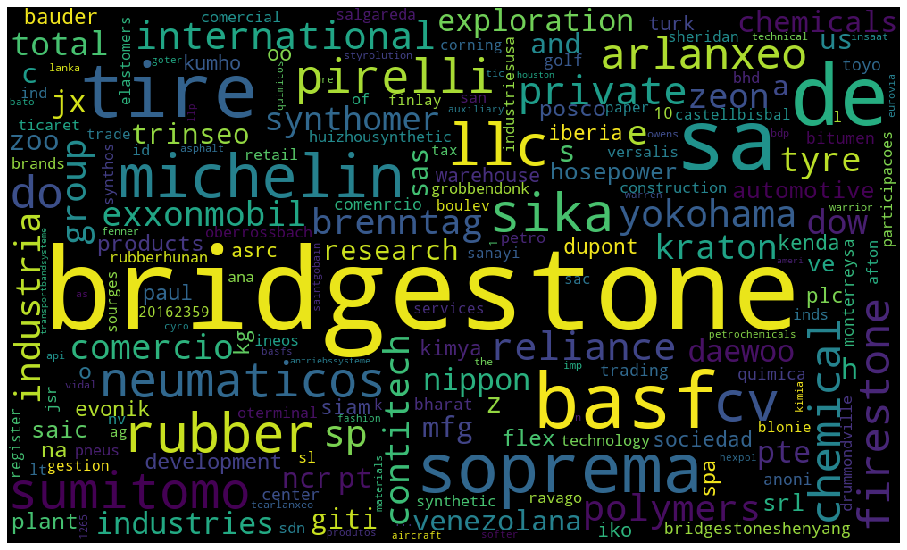

In [62]:
# Look at 100 the most high frequency words in work cloud
start = 0
stop = 250
dict_hfdupl = dict(zip(hfdupl.index[start:stop], hfdupl.frequency[start:stop]))
wordcloud = WordCloud(width=1000, height=600, random_state=0).generate_from_frequencies(dict_hfdupl)
plt.figure(figsize=(16, 10))
plt.imshow(wordcloud)
plt.axis('off');

In [63]:
# Select the names of companies by hands - look first 250 hfw
hfdupl[200:250].index

Index(['energy', 'performance', 'compounding', 'po', 'box', 'sanve', 'sumika',
       'celanese', '4549', 'colors', 'ltdsti', 'b', 'mills', 'bally', 'on',
       'auriquimica', 'freudenberg', 'nok', 'fluid', 'ticsti', 'ingredients',
       'effects', 'virgini', 'tictldsti', '6', 'industrias', 'espana',
       'company', 'bostik', 'spolka', 'anonima', 'b01', 'ryohin', 'keikaku',
       'plastics', 'fc', 'textile', 'be080...', 'springwoods', 'village',
       'spg', '22777', 'be0806160466', 'coltd', 'nl819885150', 'baytown',
       'adhesives', 'resources', 'taban', 'mitsubishi'],
      dtype='object')

In [64]:
list_top_companies_2 = ['bridgestone', 'soprema', 'michelin', 'sika', 'sumitomo', 'neumaticos', 'pirelli',
            'arlanxeo', 'firestone', 'yokohama', 'reliance', 'contitech', 'brenntag','kraton', 'total', 'dow',
             'exxonmobil', 'zeon', 'synthomer', 'daewoo', 'nippon', 'venezolana', 'trinseo', 
            'hosepower', 'posco', 'evonik', 'bauder', 'kimya', 'dupont',  'warehouse', 'kumho', 
            'bridgestoneshenyang', 'monterreysa', 'toyo', 'bharat', 'versalis', 'jsr', 'synthos', 'eurovia',
            'saintgobain','parker','basfs','antriebssysteme','transportbandsysteme', 'auriquimica',
            'mitsubishi','hannifin','celanese','freudenberg','kenda','warrior','insaat','iko',
            'joss','gobain','softer'
                       ]

In [65]:
# unite lists

list_top_companies = list(set(list_top_companies_1) | set(list_top_companies_2))
print (list_top_companies)

['exxonmobil', 'swisspor', 'goodyear', 'brenntag', 'posco', 'nippon', 'synthomer', 'gobain', 'ikea', 'iko', 'evonik', 'henkel', 'freudenberg', 'bridgestone', 'inreco', 'bauder', 'goter', 'kimya', 'kenda', 'mitsui', 'contitech', 'daewoo', 'trinseo', 'transportbandsysteme', 'celanese', 'bostik', 'mondi', 'kumho', 'ravago', 'continental', 'parker', 'bridgestoneshenyang', 'mitsubishi', 'warrior', 'reliance', 'venezolana', 'basf', 'hannifin', 'asphalt', 'synthos', 'trelleborg', 'samsung', 'monterreysa', 'zeon', 'taban', 'joss', 'arlanxeo', 'saintgobain', 'neumaticos', 'kraton', 'eurovia', 'samson', 'dow', 'paul', 'auriquimica', 'kia', 'pirelli', 'firestone', 'basfs', 'yokohama', 'mars', 'dupont', 'versalis', 'sika', 'toyo', 'warehouse', 'bharat', 'softer', 'sumitomo', 'michelin', 'hosepower', 'insaat', 'jsr', 'soprema', 'eterna', 'bituminosos', 'total', 'antriebssysteme', 'gymap']


## Matrix of names of holdings

In [66]:
holdings = list_top_companies

In [67]:
# Create matrix of top holdings and fix some columns
# FOR TRAIN
df_holdings_train = pd.DataFrame()
df_holdings_train['pair_id'] = train['pair_id']
df_holdings_train['name_1_dl'] = train['name_1_dl']
df_holdings_train['name_2_dl'] = train['name_2_dl']

# FOR TEST
df_holdings_test = pd.DataFrame()
df_holdings_test['pair_id'] = test['pair_id']
df_holdings_test['name_1_dl'] = test['name_1_dl']
df_holdings_test['name_2_dl'] = test['name_2_dl']

In [68]:
# Upgrade matrix

# There are three meanings for each holding: 0,1,2
# 0 - means no name holding in both companies of the pair
# 1 - means one name holding in any company name from a pair
# 2 - means that each company name from a pair has a name holding

df_holdings_train = df_holdings_names(df_holdings_train,train)
df_holdings_test = df_holdings_names(df_holdings_test,test)

In [69]:
# df_holdings_train.columns[0:15]

In [70]:
# columns = list(df_holdings_train.columns[0:15])

# df_holdings_train[
#     df_holdings_train['name_1_dl'].str.contains('goodyear')][
#     df_holdings_train['name_2_dl'].str.contains('goodyear')][columns]

In [71]:
# Merge data with matrix of holdings
# FOR TRAIN
train = train.merge(
    df_holdings_train.drop(['name_1_dl','name_2_dl'],axis=1), on='pair_id', how='left')

# FOR TEST
test = test.merge(
    df_holdings_test.drop(['name_1_dl','name_2_dl'],axis=1), on='pair_id', how='left')

## Dictionaries
 - most high-frequency words
 - most important words by gini index (names of holdings)

In [72]:
#  Make dictionary of frequency words
list_words = train['name_1_dl'].to_string(index=False).split() +\
                train['name_2_dl'].to_string(index=False).split()
freq_words = {}
for w in list_words:
    freq_words[w] = freq_words.get(w, 0) + 1
    
# Make a dataset from dictionary of frequency words. Aggregate and sort it
hfw = pd.DataFrame.from_dict(freq_words,orient='index')
hfw.columns = ['frequency']
hfw = hfw.sort_values(by=['frequency'], ascending=False)
hfw = hfw.drop(list_top_companies,axis=0)

# Drop 50 most frequency words

In [73]:
# Select the number of count hf words to remove
number = 50

# Create dictionary most frequency words
start,stop = 0,number
dictionary = dict(zip(hfw.index[start:stop], hfw.frequency[start:stop]))

# Remove hf words from company names
data_frames = [train,test]
old_columns = ['name_1_dl','name_2_dl']
new_columns = ['nm_1_%s' %number,'nm_2_%s' %number]
drop_hfw(dictionary,data_frames,old_columns,new_columns)

# Create LABEL with two unique values:
#     0, if no words in both names companies
#     1 in any else cases
new_column = 'lbl_empty_%s' %number
column_1 = 'nm_1_%s' %number
column_2 = 'nm_2_%s' %number
train = lbl_empty(train,column_1,column_2,new_column)
test = lbl_empty(test,column_1,column_2,new_column)

# Count some important distances after remove hf words
data_frames = [train,test]
column_1 = 'nm_1_%s' %number
column_2 = 'nm_2_%s' %number
count_distances(data_frames,column_1,column_2,number)

# Get information about simmilar and different words in the names of the companies in each pair
data_frames = [train,test]
column_1 = 'nm_1_%s' %number
column_2 = 'nm_2_%s' %number
dupl_and_diff_information(data_frames,column_1,column_2)

100%|██████████| 213249/213249 [00:17<00:00, 12303.43it/s]


In [74]:
# Check how word have been removed in the train data
columns = ['pair_id','name_1', 'name_2','target','name_1_dl','name_2_dl','nm_1_50','nm_2_50']
train[train.name_1_dl.str.contains("international")][columns].head(3)

,pair_id,name_1,name_2,target,name_1_dl,name_2_dl,nm_1_50,nm_2_50
20,21,faj international,fabrice,0,faj international,fabrice,faj,fabrice
24,25,hr international,ar,0,hr international,ar,hr,ar
25,26,sr international,cala trading group s de rl de cv,0,sr international,cala trading group s de rl de cv,sr,cala


In [75]:
# # Check how word have been removed in the test data
# test[test.name_1_dl.str.contains("international")].head(3)

In [76]:
# Check empty names after remove 50hf words
columns = ['pair_id','target','name_1_dl','name_2_dl','nm_1_50','nm_2_50',
           'rt_lvstn_50','rt_norm_lvstn_50','rt_jaro_50','rt_LCS_50']
train[train['nm_1_50']==''][train['nm_2_50']==''][columns].head(3)

,pair_id,target,name_1_dl,name_2_dl,nm_1_50,nm_2_50,rt_lvstn_50,rt_norm_lvstn_50,rt_jaro_50,rt_LCS_50
2765,2766,0,textile rubber chemical,c and e,,,NaN,NaN,inf,NaN
2856,2857,0,s k trading,trading,,,NaN,NaN,inf,NaN
7639,7640,0,al,,,,NaN,NaN,inf,NaN


In [77]:
# # Check empty names after remove 50hf words
# test[test['nm_1_50']==''][test['nm_2_50']==''].head(3)

In [78]:
# Check the new features on Train data
train[train['jaro_50']>=0.9][columns].head(3)

,pair_id,target,name_1_dl,name_2_dl,nm_1_50,nm_2_50,rt_lvstn_50,rt_norm_lvstn_50,rt_jaro_50,rt_LCS_50
161,162,1,jx nippon exploration,jx nippon exploration technical services,jx nippon exploration,jx nippon exploration technical,10.0,0.322581,0.965314,0.322581
758,759,0,24000014,24000056,24000014,24000056,2.0,0.250000,0.933333,0.250000
835,836,1,brenntag,brenntag group,brenntag,brenntag,0.0,0.000000,1.000000,0.000000


In [79]:
# Check statistics by metrics of distances
columns = ['lvstn_50', 'norm_lvstn_50', 'jaro_50', 'LCS_50']

print ('There are objects with target 0 - different companies')
display(train[train['target']==0][columns].describe().drop(['25%','75%'],axis=0))
print ()
print ('There are objects with target 1 - the duplicates')
display(train[train['target']==1][columns].describe().drop(['25%','75%'],axis=0))

There are objects with target 0 - different companies


,lvstn_50,norm_lvstn_50,jaro_50,LCS_50
count,494161.000000,494161.000000,494161.000000,494161.000000
mean,13.783269,0.846255,0.431451,0.810815
std,8.336532,0.136177,0.230238,0.149005
min,0.000000,0.000000,0.000000,0.000000
50%,12.000000,0.870968,0.488889,0.837209
max,127.000000,1.000000,1.000000,1.000000



There are objects with target 1 - the duplicates


,lvstn_50,norm_lvstn_50,jaro_50,LCS_50
count,3658.000000,3658.000000,3658.000000,3658.000000
mean,8.120011,0.384063,0.887258,0.374338
std,7.910013,0.267780,0.137078,0.261745
min,0.000000,0.000000,0.000000,0.000000
50%,7.000000,0.423077,0.916667,0.411765
max,85.000000,1.000000,1.000000,1.000000


In [80]:
# Check the important word: was it removed or not
company = 'total'
columns = ['pair_id', 'target', 'nm_1_50', 'nm_2_50',
          'rt_lvstn_50', 'rt_norm_lvstn_50', 'rt_jaro_50', 'rt_LCS_50']
print ('Check the word:', '\033[1m' + company + '\033[m')
display(train[
    train['nm_1_50'].str.contains(company)][
    train['nm_2_50'].str.contains(company)][columns].head(7))

Check the word: total


,pair_id,target,nm_1_50,nm_2_50,rt_lvstn_50,rt_norm_lvstn_50,rt_jaro_50,rt_LCS_50
1562,1563,1,total,total,0.0,0.000000,1.000000,0.000000
2815,2816,1,total bitumen,total,8.0,0.615385,0.873767,0.615385
5309,5310,1,total bitumen,total,8.0,0.615385,0.873767,0.615385
9676,9677,1,total bitumen,total petrochemicals,12.0,0.600000,0.806154,0.600000
14850,14851,1,total,total,0.0,0.000000,1.000000,0.000000
25073,25074,1,total bitumen,total z oo,7.0,0.538462,0.687179,0.538462
26199,26200,1,total,total,0.0,0.000000,1.000000,0.000000



Information about lvstn_50 

Analyse No duplicates


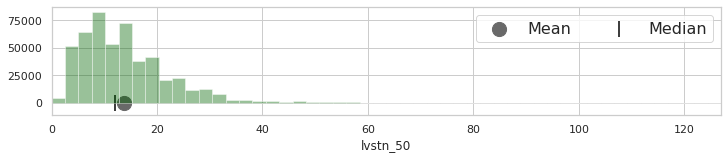

Count: 494161.0     Avg: 13.78     Std: 8.34     Median: 12.0     Min: 0.0     Max: 127.0

Analyse Duplicates


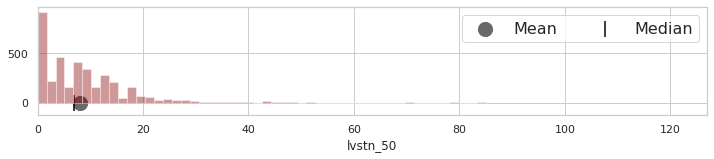

Count: 3658     Avg: 8.12     Std: 7.91     Median: 7.0     Min: 0.0     Max: 85.0
Analyse All pairs


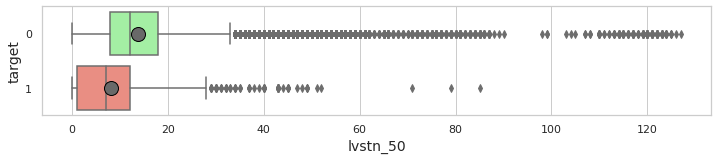

,count,mean,std,min,25%,50%,75%,max
target_0,494161.0,13.783269,8.336532,0.0,8.0,12.0,18.0,127.0
target_1,3658.0,8.120011,7.910013,0.0,1.0,7.0,12.0,85.0


In [81]:
# 
data = train
analyse = 'lvstn_50'
size = (12,2)
dd = data_statistics(data,analyse,title_print='no')
hist_fz(data,dd,analyse,size)
boxplot(data,analyse,size)
display(dd)

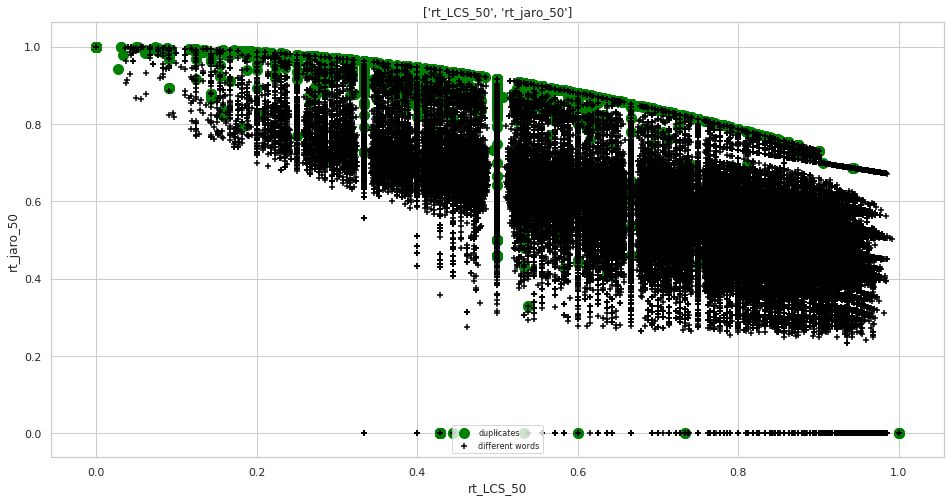

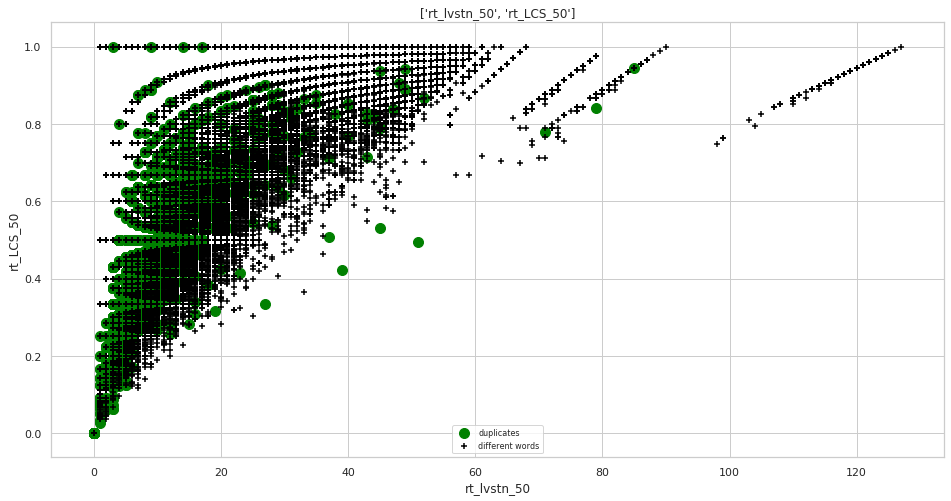

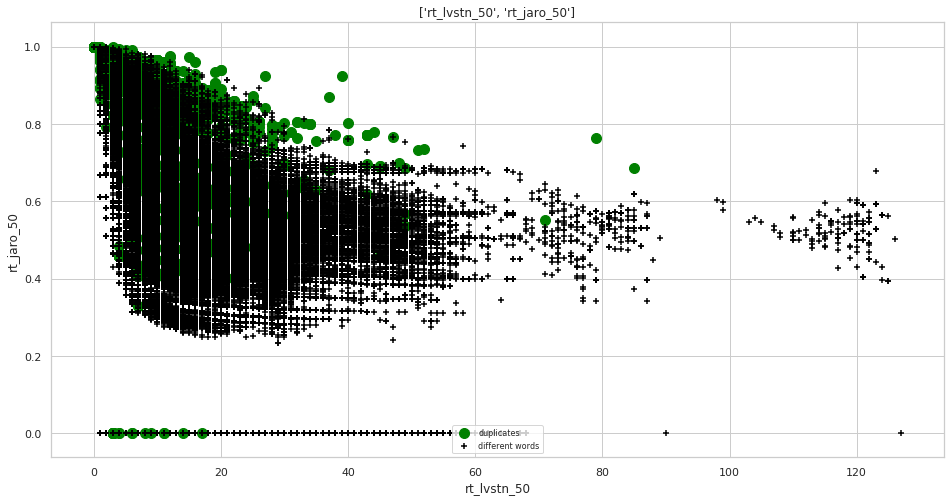

In [82]:
# scatter plot of two features (target and h/f word count)
data = train
size = (16,8)


analyse1 = 'rt_LCS_50'
analyse2 = 'rt_jaro_50'
two_features(data,analyse1,analyse2,size)

analyse1 = 'rt_lvstn_50'
analyse2 = 'rt_LCS_50'
two_features(data,analyse1,analyse2,size)

analyse1 = 'rt_lvstn_50'
analyse2 = 'rt_jaro_50'
two_features(data,analyse1,analyse2,size)

In [83]:
columns = [
    
        'pair_id', 'target', 'nm_1_50', 'nm_2_50',
       
       'duplct_wrds_50', 'dif_wrds_50', 'duplct_smbls_50',
       'dif_smbls_50', 'frst_s_50', 'last_s_50', 'subset_50', 'sum_wrds_50',
       'sum_smbls_50', 'subtr_wrds_50', 'subtr_symb_50', 
    
#         'avg_smbls_duplct_50',
#        'avg_smbls_dif_50', 'avg_frst_s_50', 'avg_last_s_50',
#        'rt_dplct_to_dif_wrds_50', 'rt_dplct_to_sum_wrds_50'
    
          ]
train[
    train['nm_1_50'].str.contains('total')][
    train['nm_2_50'].str.contains('total')][columns].head(7)

,pair_id,target,nm_1_50,nm_2_50,duplct_wrds_50,dif_wrds_50,duplct_smbls_50,dif_smbls_50,frst_s_50,last_s_50,subset_50,sum_wrds_50,sum_smbls_50,subtr_wrds_50,subtr_symb_50
1562,1563,1,total,total,1,0,5,0,5,5,True,1,5,1,5
2815,2816,1,total bitumen,total,1,1,5,7,5,0,True,2,12,0,-2
5309,5310,1,total bitumen,total,1,1,5,7,5,0,True,2,12,0,-2
9676,9677,1,total bitumen,total petrochemicals,1,2,5,21,5,0,False,3,26,-1,-16
14850,14851,1,total,total,1,0,5,0,5,5,True,1,5,1,5
25073,25074,1,total bitumen,total z oo,1,3,5,10,5,0,False,4,15,-2,-5
26199,26200,1,total,total,1,0,5,0,5,5,True,1,5,1,5


In [84]:
columns = [
    
        'pair_id', 'target', 'nm_1_50', 'nm_2_50',
       
       'duplct_wrds_50', 'dif_wrds_50', 'duplct_smbls_50',
       'dif_smbls_50', 'frst_s_50', 'last_s_50', 'subset_50', 'sum_wrds_50',
       'sum_smbls_50', 'subtr_wrds_50', 'subtr_symb_50', 
    
#         'avg_smbls_duplct_50',
#        'avg_smbls_dif_50', 'avg_frst_s_50', 'avg_last_s_50',
#        'rt_dplct_to_dif_wrds_50', 'rt_dplct_to_sum_wrds_50'
    
          ]

train[train['duplct_wrds_50']>0][columns].head(3)

,pair_id,target,nm_1_50,nm_2_50,duplct_wrds_50,dif_wrds_50,duplct_smbls_50,dif_smbls_50,frst_s_50,last_s_50,subset_50,sum_wrds_50,sum_smbls_50,subtr_wrds_50,subtr_symb_50
52,53,0,esterline defense technologies,home fashion technologies,1,4,12,27,0,12,False,5,39,-3,-15
92,93,0,owl transportes internacionais,schenker do internacionais l,1,5,14,25,0,0,False,6,39,-4,-11
106,107,0,sanhe yinpaihe automotive parts,ari automotive rentals,1,5,10,28,0,1,False,6,38,-4,-18


In [85]:
# test[test['duplct_wrds_50']>0].head(3)

# Drop 50,200,250,300,350,500 most frequency words and create features

In [86]:
# Select the number of count hf words to remove
numbers = [200,250,300,350,500]

for number in numbers:

    # Create dictionary most frequency words
    start,stop = 0,number
    dictionary = dict(zip(hfw.index[start:stop], hfw.frequency[start:stop]))

    # Remove hf words from company names
    data_frames = [train,test]
    old_columns = ['name_1_dl','name_2_dl']
    new_columns = ['nm_1_%s' %number,'nm_2_%s' %number]
    drop_hfw(dictionary,data_frames,old_columns,new_columns)

    # Create LABEL with two unique values:
    #     0, if no words in both names companies
    #     1 in any else cases
    new_column = 'lbl_empty_%s' %number
    column_1 = 'nm_1_%s' %number
    column_2 = 'nm_2_%s' %number
    train = lbl_empty(train,column_1,column_2,new_column)
    test = lbl_empty(test,column_1,column_2,new_column)

    # Count some important distances after remove hf words
    data_frames = [train,test]
    column_1 = 'nm_1_%s' %number
    column_2 = 'nm_2_%s' %number
    count_distances(data_frames,column_1,column_2,number)

    # Get information about simmilar and different words in the names of the companies in each pair
    data_frames = [train,test]
    column_1 = 'nm_1_%s' %number
    column_2 = 'nm_2_%s' %number
    dupl_and_diff_information(data_frames,column_1,column_2)

100%|██████████| 213249/213249 [00:13<00:00, 16046.22it/s]


In [87]:
train.columns

Index(['pair_id', 'name_1', 'name_2', 'target', 'name_1_dl', 'name_2_dl',
       'exxonmobil_sum', 'swisspor_sum', 'goodyear_sum', 'brenntag_sum',
       ...
       'sum_wrds_500', 'sum_smbls_500', 'subtr_wrds_500', 'subtr_symb_500',
       'avg_smbls_duplct_500', 'avg_smbls_dif_500', 'avg_frst_s_500',
       'avg_last_s_500', 'rt_dplct_to_dif_wrds_500',
       'rt_dplct_to_sum_wrds_500'],
      dtype='object', length=259)

# Ratios

In [88]:
distances =[(50,200),(50,250),(50,300),(50,350),(50,500)]

for distance in distances:
    train = ratios(train,distance[0],distance[1])
    
for distance in distances:
    test = ratios(test,distance[0],distance[1])

In [89]:
train.columns

Index(['pair_id', 'name_1', 'name_2', 'target', 'name_1_dl', 'name_2_dl',
       'exxonmobil_sum', 'swisspor_sum', 'goodyear_sum', 'brenntag_sum',
       ...
       'mult_frst_s_50_350', 'mult_avg_frst_s_50_350',
       'mult_rt_dplct_to_sum_wrds_50_350', 'rt_duplct_to_dif_wrds_50_350',
       'mult_avg_smbls_duplct_50_500', 'mult_smbls_duplct_50_500',
       'mult_frst_s_50_500', 'mult_avg_frst_s_50_500',
       'mult_rt_dplct_to_sum_wrds_50_500', 'rt_duplct_to_dif_wrds_50_500'],
      dtype='object', length=289)

# Fix errors in data markup

In [90]:
# pair_id_fix = [329529,104190,477735,477735,102161,479892,153045,459282,212424,60387,257467,10826,259275,
#               39587,489487,437771,229933,375411,76668,435014,255511,8224,30560,493021,212744,264480,
#               31144,277193,379630,
              
#               46430,221869,342874,227492,481344,477568,203810,256903,219262,350719,351047,293951,85392,
#                59511,497176,462430,371528,289342,291315,187191,335747,401164,211481,35847,178043,
               
#                366958,138516,485392,143719,425986,138647,180706,165042,25726,367913,259472,378490,327900,449961,
               
#                341323,423524,86201,110226,18985,333673,42909,17742,412644,228578,
#                 449814,339091,387407,68945,49394,277928,289569,120106,123396,162564,101448,451464,
#                 6725,33870,287052,169732,422450,43806,209101,290724,488645,298691,233833,
#                 165819,328831,129967,432312,341231,44230,433533,215365,142945,226747,381518,137440,
#                 336983,210617,417123,54658,494152,
               
#                356430, 177040, 245573, 111490, 352465, 321570, 280338, 231284, 163687, 459911, 375489, 113292,
#                 208777, 151688, 122174, 17851, 318144, 96781, 204469, 192998, 345164, 490830, 180399, 189641,
#                376986, 267397, 226334, 408335, 447342, 53116, 80558, 145698, 336868, 140744, 431544, 149243, 
#                121708, 4207
               
#               ]

In [91]:
# train['target_orig'] = text_train['target']

In [134]:
# train['target'] = text_train['target']

In [92]:
# train.loc[train['pair_id'].isin(pair_id_fix), 'target'] = 1

In [93]:
# columns = [
#     'pair_id', 'name_1','name_2','nm_1_500','nm_2_500',
    
#     'target','target_orig']


# train[columns].loc[train['pair_id'].isin(pair_id_fix)]

,pair_id,name_1,name_2,nm_1_500,nm_2_500,target,target_orig
4206,4207,continental belting,continental tire the americas llc,continental belting,continental,1,0
6724,6725,becton dickinson private ltd,becton dickinson de,becton dickinson,becton dickinson,1,0
8223,8224,weatherbeeta,weatherbeeta,weatherbeeta,weatherbeeta,1,0
10825,10826,cabdi laahi maxamuud cawda,cabdi laahi maxamuud,cabdi laahi maxamuud cawda,cabdi laahi maxamuud,1,0
17741,17742,volkswagen ag,volkswagen sa,volkswagen,volkswagen,1,0
...,...,...,...,...,...,...,...
489486,489487,shipco transport inc,shipco transport inc,shipco,shipco,1,0
490829,490830,sigma aldrich international gm,sigma aldrich international gmb h,sigma aldrich gm,sigma aldrich,1,0
493020,493021,hangzhou yokohama tire co ltd,yokohama tire,yokohama,yokohama,1,0
494151,494152,continental tire inc,continental de pegantes y soluciones sas,continental,continental pegantes soluciones,1,0


# MODELING
## Use light GBM

In [94]:
train.columns

Index(['pair_id', 'name_1', 'name_2', 'target', 'name_1_dl', 'name_2_dl',
       'exxonmobil_sum', 'swisspor_sum', 'goodyear_sum', 'brenntag_sum',
       ...
       'mult_avg_frst_s_50_350', 'mult_rt_dplct_to_sum_wrds_50_350',
       'rt_duplct_to_dif_wrds_50_350', 'mult_avg_smbls_duplct_50_500',
       'mult_smbls_duplct_50_500', 'mult_frst_s_50_500',
       'mult_avg_frst_s_50_500', 'mult_rt_dplct_to_sum_wrds_50_500',
       'rt_duplct_to_dif_wrds_50_500', 'target_orig'],
      dtype='object', length=290)

In [762]:
# select features
features = [
    
#        'inreco_sum', 'goodyear_sum',
#        'dupont_sum', 'posco_sum', 'pirelli_sum', 'bauder_sum', 'warehouse_sum',
#        'kia_sum', 'reliance_sum', 'dow_sum', 'versalis_sum', 'venezolana_sum',
#        'brenntag_sum', 'mars_sum', 'warrior_sum', 'sika_sum', 'kumho_sum',
#        'jsr_sum', 'bituminosos_sum', 'arlanxeo_sum', 'bridgestoneshenyang_sum',
#        'soprema_sum', 'zeon_sum', 'parker_sum', 'kenda_sum', 'bridgestone_sum',
#        'paul_sum', 'eurovia_sum', 'hosepower_sum', 'kraton_sum', 'samsung_sum',
#        'neumaticos_sum', 'synthomer_sum', 'goter_sum', 'basfs_sum',
#        'antriebssysteme_sum', 'sas_sum', 'gymap_sum', 'toyo_sum', 'ikea_sum',
#        'asphalt_sum', 'celanese_sum', 'transportbandsysteme_sum', 'bharat_sum',
#        'mondi_sum', 'kimya_sum', 'saintgobain_sum', 'trinseo_sum',
#        'freudenberg_sum', 'swisspor_sum', 'eterna_sum', 'mitsubishi_sum',
#        'total_sum', 'monterreysa_sum', 'exxonmobil_sum', 'samson_sum',
#        'trelleborg_sum', 'nippon_sum', 'stargard_sum', 'hannifin_sum',
#        'sumitomo_sum', 'basf_sum', 'llc_sum', 'synthos_sum', 'michelin_sum',
#        'bostik_sum', 'continental_sum', 'daewoo_sum', 'contitech_sum',
#        'firestone_sum', 'evonik_sum', 'ravago_sum', 'henkel_sum', 'taban_sum',
#        'yokohama_sum', 'mitsui_sum', 'auriquimica_sum',
    
        'mult_avg_smbls_duplct_50_300',
        'mult_smbls_duplct_50_300',
        'mult_frst_s_50_300',
        'mult_avg_frst_s_50_300',
        'mult_rt_dplct_to_sum_wrds_50_300',
        'rt_duplct_to_dif_wrds_50_300',
    
    
#       'lvstn_50', 'norm_lvstn_50',
#       'jaro_50', 'LCS_50', 
        'rt_lvstn_50', 'rt_norm_lvstn_50',
        'rt_jaro_50', 'rt_LCS_50',    
        'duplct_wrds_50', 
        'dif_wrds_50',
        'duplct_smbls_50',
        'dif_smbls_50',
        'frst_s_50', 'last_s_50',
        'subset_50','subsetr_50',
        'sum_wrds_50',
        'sum_smbls_50',
        'subtr_wrds_50',
        'subtr_symb_50',
        'avg_smbls_duplct_50',
        'avg_smbls_dif_50', 
        'avg_frst_s_50',
        'avg_last_s_50',
        'rt_dplct_to_dif_wrds_50',
        'rt_dplct_to_sum_wrds_50',
    
    
#       'lvstn_300', 'norm_lvstn_300',
#       'jaro_300', 'LCS_300', 
        'rt_lvstn_300', 'rt_norm_lvstn_300',
        'rt_jaro_300', 'rt_LCS_300',    
        'duplct_wrds_300', 
        'dif_wrds_300',
        'duplct_smbls_300',
        'dif_smbls_300',
        'frst_s_300', 'last_s_300',
        'subset_300','subsetr_300',
        'sum_wrds_300',
        'sum_smbls_300',
        'subtr_wrds_300',
        'subtr_symb_300',
        'avg_smbls_duplct_300',
        'avg_smbls_dif_300', 
        'avg_frst_s_300',
        'avg_last_s_300',
        'rt_dplct_to_dif_wrds_300',
        'rt_dplct_to_sum_wrds_300'
                   
           ]

seed = 42

# provides train/test indices to split data in train/test sets
split = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=seed)

tridx, cvidx = list(split.split(train[features],
                                train["target"]))[0]

print ('Split baseline data train',train.shape[0])
print (' - new train data:',tridx.shape[0])
print (' - new test data:',cvidx.shape[0])

Split baseline data train 497819
 - new train data: 398255
 - new test data: 99564


In [763]:
# set parametres
seed = 50
params = {'n_estimators': 500,
          'objective': 'binary',
          'max_depth': 3,
          'min_child_samples': 15,
          'learning_rate': 0.01,
          'subsample': 0.75,
          'colsample_bytree': 0.42,
#           'min_split_gain': 200,
#           'min_child_weight': 40,
          'random_state': seed}

# learning Light GBM Classificier
model = lgb.LGBMClassifier(**params)
model.fit(train.iloc[tridx][features].values,
          train.iloc[tridx]["target"].values)

# make predict proba and predict target on train data
train['predict_proba'] = 1-(model.predict_proba(
    train[features].values)[:, 0].astype(np.float))

# select the probability level
probability_level = get_threshold(train.iloc[cvidx]['target'], train.iloc[cvidx]['predict_proba'])
print ('\033[1m'+'Probability level:',probability_level.round(2),'\033[m')
print ()

# make predict proba and predict target
X = train
tridx = tridx
cvidx = cvidx
model = model

X_tr, X_cv = contingency_table(X,features,probability_level,tridx,cvidx,model)

train_matrix_confusion = matrix_confusion(X_tr)
cv_matrix_confusion = matrix_confusion(X_cv)

# check the report
report_score(train_matrix_confusion,
             cv_matrix_confusion,
             train,
             tridx,cvidx,
             X_tr,X_cv)

Probability level: 0.56 

Matrix confusion on train data


,0_algorythm,1_algorythm
0_target,394828.0,501.0
1_target,511.0,2415.0



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    395329
           1       0.83      0.83      0.83      2926

    accuracy                           1.00    398255
   macro avg       0.91      0.91      0.91    398255
weighted avg       1.00      1.00      1.00    398255

******************************************************


Matrix confusion on test(cv) data


,0_algorythm,1_algorythm
0_target,98710.0,122.0
1_target,127.0,605.0



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98832
           1       0.83      0.83      0.83       732

    accuracy                           1.00     99564
   macro avg       0.92      0.91      0.91     99564
weighted avg       1.00      1.00      1.00     99564

******************************************************


In [668]:
# X_tr.columns

In [667]:
# columns = ['pair_id','name_1','name_2','target',
# #            'name_1_dl','name_2_dl',
#            'nm_1_50','nm_2_50','nm_1_300','nm_2_300',
#           'rt_jaro_300','duplct_wrds_300']

# data = train
# data[columns][train['duplct_wrds_300']>0][train['target']==0][train['rt_jaro_300']>0.8]

In [666]:
# columns = ['pair_id','name_1','name_2','target','target_orig','predict_target','predict_proba',
# #            'name_1_dl','name_2_dl',
#            'nm_1_50','nm_2_50','nm_1_300','nm_2_300',
#           'rt_jaro_300','duplct_wrds_300']

# data = X_tr
# data[columns][data['False_Negative']==1][0:50]

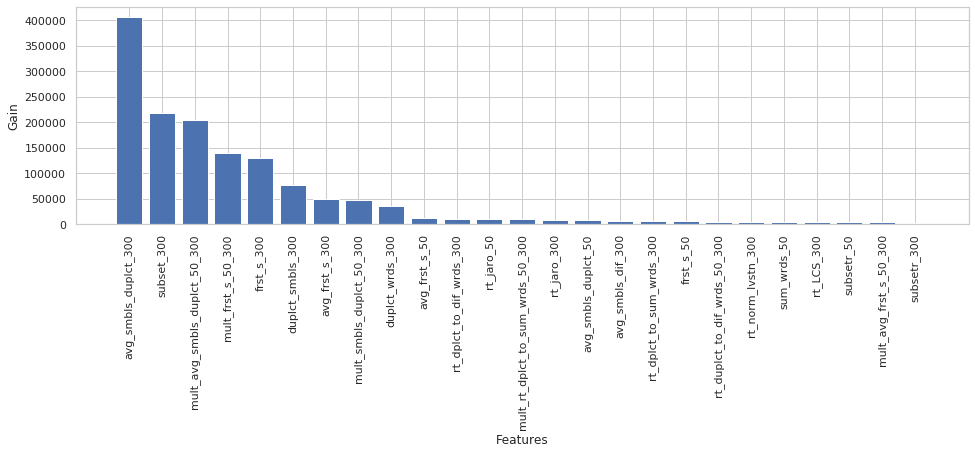

,Features,Gain
44,avg_smbls_duplct_300,406447.908281
38,subset_300,219313.212799
0,mult_avg_smbls_duplct_50_300,204230.448724
2,mult_frst_s_50_300,140140.065521
36,frst_s_300,131033.466372
34,duplct_smbls_300,77690.938826
46,avg_frst_s_300,49452.690477
1,mult_smbls_duplct_50_300,47530.954904
32,duplct_wrds_300,36287.255600
24,avg_frst_s_50,11424.253561


In [764]:
# look at the graph of the most gain information in the features
start,stop = 0,25
size = (16,4)

df = table_gain_coef(model,features,start,stop)
gain_hist(df,size,start,stop)
display(df)

## Cross Validation on train data

In [704]:
features = features

SEED = 50
FOLDS = 5
PARAMS = params

df_scores = pd.DataFrame()

In [729]:
df_cv,scores,tridx,cvidx = crosvalscore_lgbm_classifier(train,features,PARAMS)

df_scores['model_50_500'] = scores

fold: 1 , score: 0.8365 , time: 20:36:18
fold: 2 , score: 0.8328 , time: 20:36:31
fold: 3 , score: 0.8455 , time: 20:36:44
fold: 4 , score: 0.8271 , time: 20:37:00
fold: 5 , score: 0.8416 , time: 20:37:14


In [730]:
df_scores.round(4)

,model_50_250,model_50_300,model_50_350,model_50_500
0,0.8237,0.8271,0.8386,0.8365
1,0.8123,0.8183,0.8278,0.8328
2,0.8256,0.8313,0.8436,0.8455
3,0.8082,0.8155,0.8238,0.8271
4,0.8205,0.8270,0.8329,0.8416


In [731]:
df_scores.describe().round(4)

,model_50_250,model_50_300,model_50_350,model_50_500
count,5.0000,5.0000,5.0000,5.0000
mean,0.8181,0.8238,0.8334,0.8367
std,0.0075,0.0066,0.0080,0.0072
min,0.8082,0.8155,0.8238,0.8271
25%,0.8123,0.8183,0.8278,0.8328
50%,0.8205,0.8270,0.8329,0.8365
75%,0.8237,0.8271,0.8386,0.8416
max,0.8256,0.8313,0.8436,0.8455


In [669]:
# # CHECK ANY FOLD IF YOU NEED IT
# # Select the number of fold
# num = 4
# model = lgb.LGBMClassifier(**PARAMS)
# model.fit(train.loc[tridx[num]][features].values,
#           train.loc[tridx[num]]["target"].values)

# # make predict proba and predict target on train data
# train['predict_proba'] = 1-(model.predict_proba(
#     train[features].values)[:, 0].astype(np.float))


# # select the probability level
# probability_level = get_threshold(train.loc[cvidx[num]]['target'], train.loc[cvidx[num]]['predict_proba'])
# print ('\033[1m'+'Probability level:',probability_level.round(4),'\033[m')
# print ()

# # make predict proba and predict target
# X = train
# tridx = tridx
# cvidx = cvidx
# model = model

# X_tr, X_cv = contingency_table(X,features,probability_level,tridx[num],cvidx[num],model)

# train_matrix_confusion = matrix_confusion(X_tr)
# cv_matrix_confusion = matrix_confusion(X_cv)

# # check the report
# report_score(train_matrix_confusion,
#              cv_matrix_confusion,
#              train,
#              tridx[num],cvidx[num],
#              X_tr,X_cv)

## The last check

Probability level: 0.45 

Predict balance on the train data:
0    493719
1      4100
Name: predict_to_csv, dtype: int64

Predict balance on the test data
0    212032
1      1217
Name: predict_to_csv, dtype: int64

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    494161
           1       0.78      0.88      0.83      3658

    accuracy                           1.00    497819
   macro avg       0.89      0.94      0.91    497819
weighted avg       1.00      1.00      1.00    497819

Look how predict proba (that the pair contains the common companys)


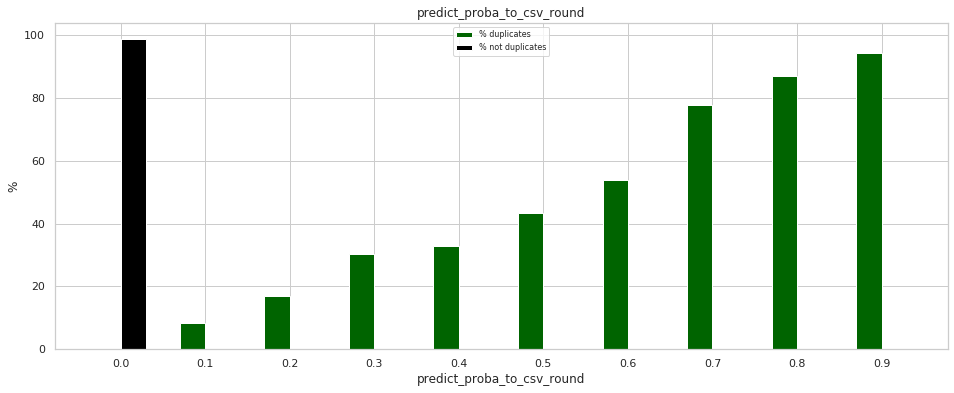

predict_proba_to_csv_round,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
target,,,,,,,,,,
0,491712.00,828.00,300.0,188.00,236.00,207.00,285.00,203.00,133.00,69.0
1,122.00,75.00,61.0,82.00,115.00,158.00,331.00,711.00,883.00,1120.0
sum,491834.00,903.00,361.0,270.00,351.00,365.00,616.00,914.00,1016.00,1189.0
duplicates_%_(1),0.02,8.31,16.9,30.37,32.76,43.29,53.73,77.79,86.91,94.2
share_of_objects_%,98.80,0.20,0.1,0.10,0.10,0.10,0.10,0.20,0.20,0.2



Look at the scatter plot of predict proba and feature


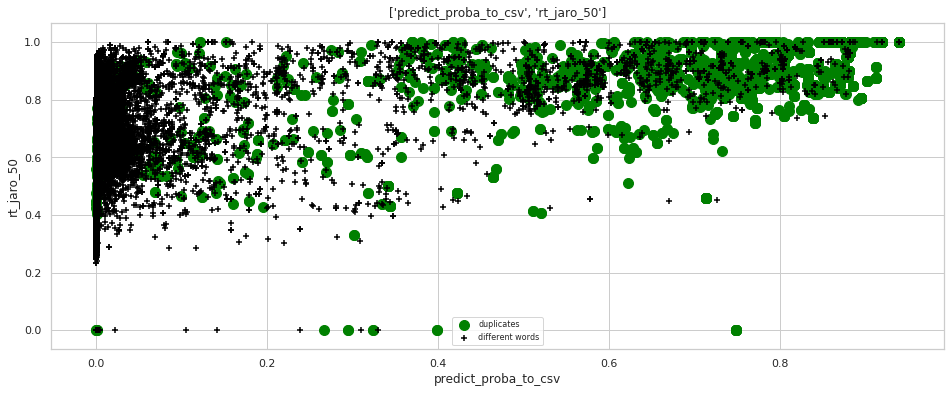

In [765]:
# fit the model
model = lgb.LGBMClassifier(**params)
model.fit(train[features].values,
          train["target"].values)

# make predict proba and predict target on train data
train['predict_proba'] = 1-(model.predict_proba(
    train[features].values)[:, 0].astype(np.float))

# select the probability level
probability_level = get_threshold(train['target'], train['predict_proba'])
print ('\033[1m'+'Probability level:',probability_level.round(2),'\033[m')
print ()

# make predict proba and predict target on train data
train['predict_to_csv'] = (model.predict_proba(
    train[features].values)[:, 1] > probability_level).astype(np.int)

# make predict proba and predict target on test data
test['predict_to_csv'] = (model.predict_proba(
    test[features].values)[:, 1] > probability_level).astype(np.int)

# predict balance on train
print ('\033[1m'+'Predict balance on the train data:'+'\033[m')
print (train['predict_to_csv'].value_counts())
print ()
# predict balance on test
print ('\033[1m'+'Predict balance on the test data'+'\033[m')
print (test['predict_to_csv'].value_counts())
print ()
# report about precision, recall and f-1 score
print ('\033[1m'+'Classification report:'+'\033[m')
print (classification_report(train["target"].values, train['predict_to_csv']))

# make predict proba and predict target on train data
train['predict_proba_to_csv'] = 1-(model.predict_proba(
    train[features].values)[:, 0].astype(np.float))

# make predict proba and predict target on test data
test['predict_proba_to_csv'] = 1-(model.predict_proba(
    test[features].values)[:, 0].astype(np.float))

# make vizualization
print ('\033[1m'+'Look how predict proba (that the pair contains the common companys)'+'\033[m')
train['predict_proba_to_csv_round'] = train['predict_proba_to_csv'].round(1)
data = train
analyse = 'predict_proba_to_csv_round'
title_print = 'no'
size = (16,6)
ct = contingency_table_2(data,analyse,title_print)
pair_hist(ct,size,title_print)
display(ct)
print ()
# scatter plot of two features (target and h/f word count)
print ('\033[1m'+'Look at the scatter plot of predict proba and feature'+'\033[m')
data = train
analyse1 = 'predict_proba_to_csv'
analyse2 = 'rt_jaro_50'
two_features(data,analyse1,analyse2,size)

In [766]:
# select only dublicates names and look id, each name of companies and predict is the duplicate
columns = ['pair_id','name_1','name_2','nm_1_300','nm_2_300','predict_to_csv']
test[test['predict_to_csv']==1][columns]

,pair_id,name_1,name_2,nm_1_300,nm_2_300,predict_to_csv
40,41,continental air control ltd,continental powertrain usa llc,continental control,continental powertrain,1
306,307,canadian saddlery supply inc,canadian saddlery supply in,saddlery,saddlery,1
362,363,trelleborg ysh sa de cv,trelleborg engineeed products a,trelleborg ysh,trelleborg engineeed,1
773,774,henkel industrie ag no 3 5 th floor,henkel corporation,henkel no 5 th floor,henkel,1
829,830,mol logistics incdallas,mol logistics gmb h,mol incdallas,mol,1
...,...,...,...,...,...,...
211824,211825,ceva freight management,ceva international inc,ceva,ceva,1
211827,211828,sojitz co ltd,sojitz,sojitz,sojitz,1
211951,211952,sanyo corp,sanyo trading,sanyo,sanyo,1
212072,212073,goodyear do brasil productos de borracha ltda,goodyear inc,goodyear borracha,goodyear,1


In [767]:
# select only NOT dublicates names and look id, each name of companies and predict is the duplicate
test[test['predict_to_csv']==0][columns]

,pair_id,name_1,name_2,nm_1_300,nm_2_300,predict_to_csv
0,1,sun blinds decoration inc,indl de cuautitlan sa cv,sun blinds decoration,indl cuautitlan,0
1,2,eih ltd,dongguan wei shi plastic product co ltd,,shi,0
2,3,jsh ltd,arab shipbuilding and repair yard c,jsh,shipbuilding repair yard,0
3,4,better industrial ltd,farmacap industria e comercio ltda,better,farmacap,0
4,5,equipos inoxidables del norte sa de cv,bel inc,equipos inoxidables norte,,0
...,...,...,...,...,...,...
213244,213245,dyna logistics inc,jiangsu easero logistics ltd,dyna,easero,0
213245,213246,dsi,kavalani sons wll,,kavalani sons,0
213246,213247,saint gobain abrasives,zarabi,saint gobain abrasives,zarabi,0
213247,213248,covestro private ltd,terabytes private ltd,covestro,terabytes,0


# Download submission

In [768]:
# download sample submission from csv file 
sample_sub = pd.read_csv('sample_submission.csv', index_col="pair_id")
# make the predict - our vector of answers
sample_sub['is_duplicate'] = (model.predict_proba(
    test[features].values)[:, 1] > probability_level).astype(np.int)
# download predict to csv file
sample_sub.to_csv('201227_5_300_submission.csv')

## Check the score  (f1 on test samples)

## The score is - 0.6104/0.6497